# Phase Locked Loop (PLL)

The PLL is used in synchronization applications (e.g., clock recovery of received signal)

References:
1. [Unlocking the Phase Locked Loop](http://complextoreal.com/tutorials/tutorial-18-unlocking-the-phase-locked-loop-pll-part-1/), by Charan Langton, **complextoreal.com**
2. [Creating lowpass filter in SciPy - understanding methods and units](https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units), Stack Overflow

A **Phase Locked Loop** consists of:
1. A **phase detector**
2. A low-pass filter called a **loop filter**
3. A **voltage controlled oscillator**, or VCO

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import kaiserord, butter, lfilter, firwin, freqz
import seaborn as sns
sns.set()

Some helper functions to generate and plot signals:

In [161]:
# Signal Generator Parameters:
freq = 3.0 # Hz
duration = 100.0 # seconds
oversamp = 10 # oversampling rate
Fs = freq*oversamp # samples per second

In [3]:
def sig_gen(freq, duration, Fs, phase_delta=0.0, complex=False):
    omega = 2*np.pi*freq
    t = np.linspace(0,duration, int(duration*Fs))
    if phase_delta == 0.0:
        if complex: return np.exp(-1j*(omega*t))
        else: return np.real(np.exp(-1j*(omega*t)))
    else:
        if complex: return np.exp(-1j*(omega*t + phase_delta))
        else: return np.real(np.exp(-1j*(omega*t + phase_delta)))
        

In [164]:
def plot_signals(sig_list, truncate=True):
    fig, ax = plt.subplots()
    if truncate:
        for index, signal in enumerate(sig_list):
            sig_list[index] = signal[:100]
    for index, signal in enumerate(sig_list):
        ax.plot(signal, label=('Signal '+str(index + 1)))
    ax.set_xlabel('Sample')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='upper left')
    fig.tight_layout()
    return fig, ax

def plot_fft(sig_list, sample_period=None):
    if sample_period==None:
        sample_period=1.0
    fig, ax = plt.subplots()
    for index, signal in enumerate(sig_list):
        ax.plot(np.fft.fftfreq(len(signal), sample_period), np.absolute(np.fft.fft(signal)), label=('Signal '+str(index +1)))
    ax.set_xlabel('fft bin')
    ax.set_ylabel('mag fft coeff')
    ax.legend(loc='upper left')
    fig.tight_layout()
    return fig, ax

def plot_both(sig_list, sample_period=None, truncate=True):
    if sample_period==None:
        sample_period=1.0
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    # time domain plot:
    if truncate:
        for index, signal in enumerate(sig_list):
            sig_list[index] = signal[:100]
    for index, signal in enumerate(sig_list):
        axs[0].plot(np.real(signal), label=('Signal '+str(index + 1)))
    axs[0].set_xlabel('Sample')
    axs[0].set_ylabel('Amplitude')
    axs[0].legend(loc='upper left')
    axs[0].set_title('Time Domain (Real)')
    # freq domain plot:
    for index, signal in enumerate(sig_list):
        axs[1].plot(np.fft.fftfreq(len(signal), sample_period), np.absolute(np.fft.fft(signal)), label=('Signal '+str(index +1)))               
#        axs[1].stem(np.fft.fftfreq(len(signal), sample_period), np.absolute(np.fft.fft(signal)), label=('Signal '+str(index +1)))        
        #axs[1].plot(np.absolute(np.fft.fft(signal)), label=('Signal '+str(index +1)))
    axs[1].set_xlabel('FFT bin (Hz)')
    axs[1].set_ylabel('mag FFT coeff')
    axs[1].legend(loc='upper left')
    axs[1].set_title('Freq Domain')
    fig.tight_layout()
    return fig, axs
    

In [165]:
a = sig_gen(freq, duration, Fs) # cosine
b = sig_gen(freq, duration, Fs, np.pi/2) # sine

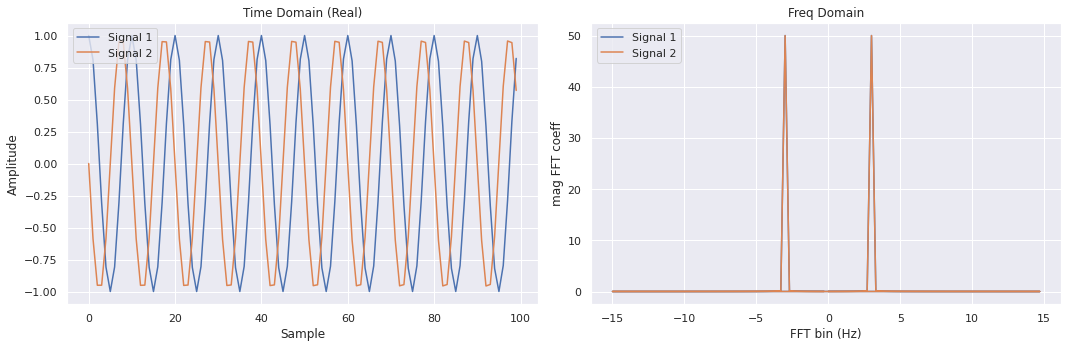

In [166]:
fig, axs = plot_both([a,b], sample_period=1/Fs)

In [181]:
a = sig_gen(freq, duration, Fs, complex=True)
b = sig_gen(freq, duration, Fs, np.pi/2, complex=True) # 90-degree phase delta

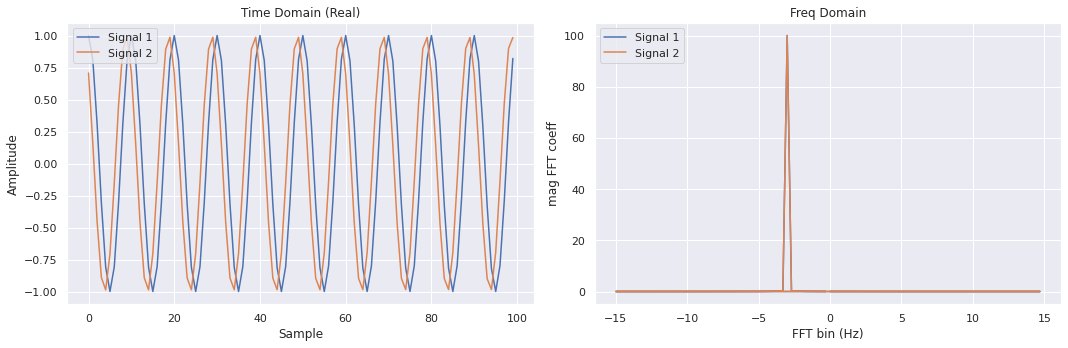

In [176]:
fig, axs = plot_both([a,b], sample_period=1/Fs)

*Peak is at -3 Hz instead of +3 Hz since I use the $-j$ convention for clockwise rotation to generate my sinusoids... (I think?)

## The Phase Detector

A **phase detector** is simply a multiplier.  Say I have two signals:

$$s_1(t) = A_1sin({\omega}t + {\phi}_1(t))$$

$$s_2(t) = A_2cos({\omega}t + {\phi}_2(t))$$

Multiplying these signals together gives me a third signal:

$$s_3(t) = s_1(t)s_2(t) = A_1A_2sin({\omega}t + {\phi}_1(t))cos({\omega}t + {\phi}_2(t))$$

Which can be written as:

$$s_3(t) = \frac{A_1A_2}{2}sin(\phi_1(t) - \phi_2(t)) + \frac{A_1A_2}{2}sin(2\omega t + \phi_1(t) + \phi_2(t))$$

The first term is directly proportional to the phase difference between the two signals.  The second term is periodic at twice the frequency of interest, so we will filter it out using a low-pass filter (the "loop filter")

In [177]:
# Phase Detector
def phase_detect(a, b, Km=1.0):
    return Km*a*b

(<Figure size 1080x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f72b43f08d0>,
       dtype=object))

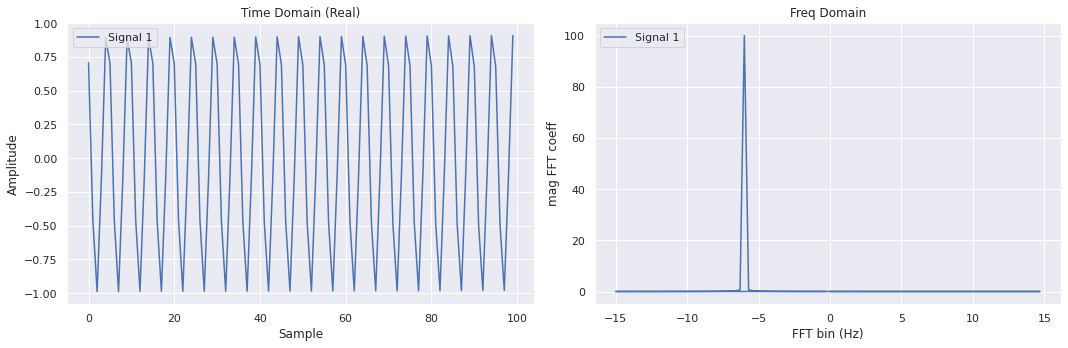

In [178]:
plot_both([phase_detect(a,b)], sample_period=1/Fs)

As we can see, the frequency of the resulting signal is twice that of the original two signals (-6 Hz instead of -3 Hz).  We want to filter this out.

## The Loop Filter

I relied heavily on [this stack overflow post](https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units) for boilerplate code and figuring out how to apply a lowpass filter.

In [146]:
# Loop Filter (low-pass filter, used to filter out the high frequency components of the phase detector output)
# using reference: https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [179]:
# build the filter:
order = 25 # number of taps
fs = Fs # sample rate, Hz
cutoff = freq

num, den = butter_lowpass(cutoff, fs, order) # taps (numerator, denominator)

w, h = freqz(num, den, worN=512) # compute the frequency response of the filter
# worN is the number of frequencies for which we want the freq response
# w is an array of frequencies (in rad/sample period)
# h is an array of complex numbers representing the frequency response (take the magnitude)

# NOTE: if I want to convert w into Hz, I need to convert rad/sample period into cycles/second
w = (w/(2*np.pi))*fs

*NOTE: I am not sure why the scipy butterworth filter function returns a separate array of numerator and denominator terms for the filter taps...*

When multiplying complex numbers, the product will be a complex number such that:
1. The magnitude of the product is the product of the magnitudes of the original numbers
2. The angle of the product is the sum of the angles of the original numbers

Text(0.5, 0, '(Hz)')

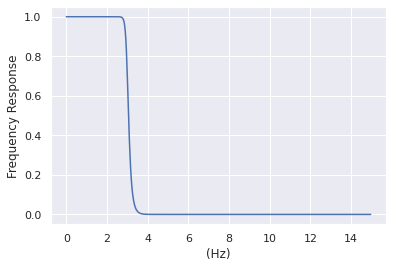

In [172]:
# Plot the frequency response of our filter:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(w, np.abs(h))
ax.set_ylabel("Frequency Response")
ax.set_xlabel("(Hz)")

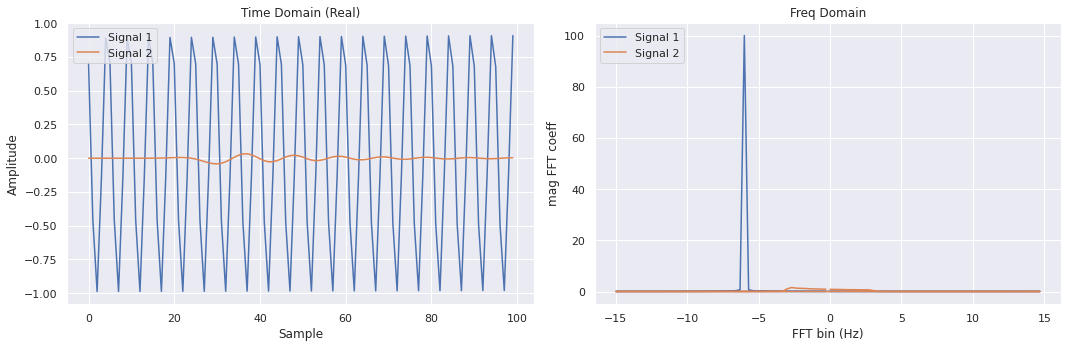

In [180]:
# Apply filter to the phase detector output:
signal = phase_detect(a,b)
filtered = lfilter(num, den, signal)

# Plot:
fix, ax = plot_both([signal, filtered], sample_period=1/Fs)

The lowpass filter definitely worked, but I don't see any DC component in the filtered result!  I was expecting to see something that reflects the $\frac{\pi}{2}$ phase difference...

**This is where I am failing...**

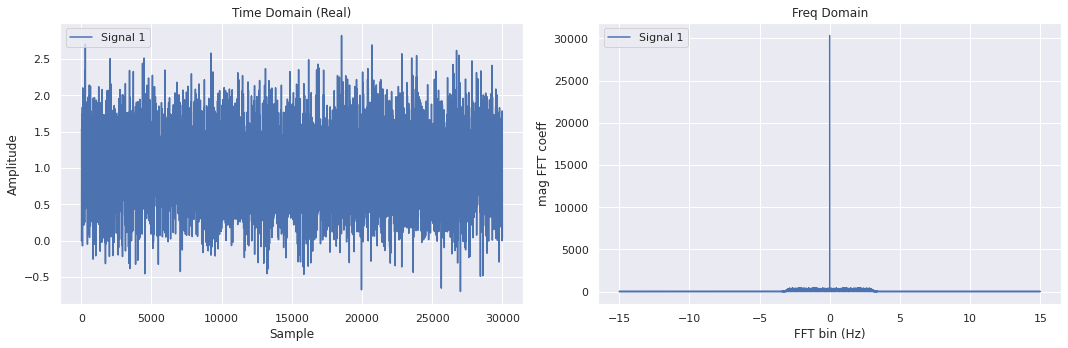

In [174]:
# Testing out the LPF with a noisy signal and DC offset:

# Create gaussian white noise signal:
SNR = 0.0 # dB
N = duration*Fs*oversamp # number of samples
awgn_signal = np.random.normal(0, np.sqrt(np.power(10,-SNR/10)), int(N))
awgn_signal += 1.0 # add a DC offset

# Plot:
fix, axs = plot_both([lfilter(num, den, awgn_signal)], sample_period=1/Fs, truncate=False)

*I can see that my loop filter is not removing DC offset...*

In [90]:
# Generate test signals:

freq = 3.0 # Hz
duration = 1.0 # seconds
oversamp = 5
Fs = oversamp*freq # samples per second (2*freq for nyquist rate)

sig_1 = sig_gen(freq, duration, Fs, complex=True) # cosine
sig_2 = sig_gen(freq, duration, Fs, np.pi/2, complex=True) # sine, 90 deg phase shift

In [102]:
type(ax[0])

matplotlib.lines.Line2D

## Lowpass filter tutorial from stackoverflow

Ref: https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

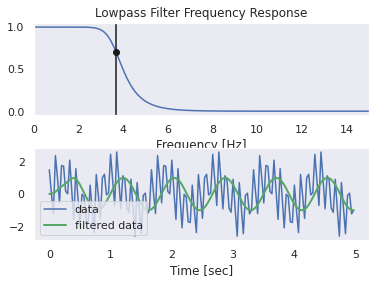

In [86]:
# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

## Failed attempts at applying a handbuilt FIR lowpass filter

In [ ]:
# Loop Filter (low-pass filter, used to filter out the high frequency components of the phase detector output)

def low_pass_filter_taps(fc, num_taps, Fs):
    assert isinstance(num_taps, int), "must have integer number of coefficients!"
    omega = 2*np.pi*fc/Fs # normalized cutoff frequency (rad/sample)
    if num_taps%2 == 0:
        num_taps = num_taps + 1 # force odd number of taps for simplicity
    # build filter taps:
    x = np.linspace(1,(num_taps-1)/2,(num_taps-1)/2) # positive side (will mirror for negative)
    cycles = 2 # number of sinc cycles per sideband
    factor = ((num_taps-1)/2)/(cycles*2*np.pi) # scaling factor
    x = x*factor # scale to achieve desired sinc cycles per sideband
    taps = np.sin(omega*x)/(np.pi*x) # compute impulse response (sinc function)
    taps = np.concatenate((np.flip(taps), np.array([taps[0]]),taps))
    x = np.concatenate((-np.flip(x), np.array([0.0]), x))
    return x, taps

In [ ]:
# Loop Filter (low-pass filter, used to filter out the high frequency components of the phase detector output)

def low_pass_filter_taps(fc, num_taps, Fs):
    assert isinstance(num_taps, int), "must have integer number of coefficients!"
    omega = 2*np.pi*fc/Fs # normalized cutoff frequency (rad/sample)  
    if num_taps%2 == 0:
        num_taps = num_taps + 1 # force odd number of taps for simplicity
    # build filter taps:
    x = np.linspace(1,(num_taps-1)/2,(num_taps-1)/2) # positive side (will mirror for negative)
    cycles = 2 # number of sinc cycles per sideband
    factor = ((num_taps-1)/2)/(cycles*2*np.pi) # scaling factor
    x = x*factor # scale to achieve desired sinc cycles per sideband
    taps = np.sin(omega*x)/(np.pi*x) # compute impulse response (sinc function)
    taps = np.concatenate((np.flip(taps), np.array([taps[0]]),taps))
    x = np.concatenate((-np.flip(x), np.array([0.0]), x))
    taps = (1/(2*np.pi*1j*x))*(np.exp(1j*omega*x) - np.exp(-1j*omega*x))
    return x, taps

In [ ]:
taps

In [ ]:
x, taps = low_pass_filter_taps(5.0, 35, 1000.0)

fig, ax = plt.subplots()
ax.plot(x, taps)

In [ ]:
def low_pass_filter_taps(fc, num_taps, Fs):
    #------------------------------------------------
    # Create a FIR filter and apply it to x.
    #------------------------------------------------

    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0

    # The desired width of the transition from pass to stop,
    # relative to the Nyquist rate.  We'll design the filter
    # with a 5 Hz transition width.
    width = 5.0/nyq_rate

    # The desired attenuation in the stop band, in dB.
    ripple_db = 60.0

    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)

    # The cutoff frequency of the filter.
    cutoff_hz = fc

    # Use firwin with a Kaiser window to create a lowpass FIR filter.
    taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
    
    if len(taps)%2 == 0:
        x = np.arange(-int(len(taps)/2), int(len(taps)/2))
    else:
        x = np.arange(0, int(len(taps)/2))
        x = np.concatenate((-np.flip(x),np.array([0.0]),x))
    
    return x, taps

In [ ]:
def apply_filter(signal, taps):
    return np.convolve(signal, taps)
#    return np.array([np.convolve(xi, taps, mode='valid') for xi in signal])

In [ ]:
def apply_filter(signal, taps):
    return lfilter(taps, 1.0, signal)

In [ ]:
x, taps = low_pass_filter_taps(0.4*np.pi/(2*np.pi), num_taps=100, Fs=Fs)

In [ ]:
cutoff_freq = 10
M = [15, 30, 200, 1000]
Fs = 1000.0

signal_low = sig_gen(freq=5.0, duration = 10.0, Fs = Fs)
signal_high = sig_gen(freq=100.0, duration = 10.0, Fs = Fs)
signal = signal_low + signal_high

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].plot(signal)
ax[0].set_title('Time Domain')
ax[1].plot(np.fft.fft(signal[:1024]))
ax[1].set_title('Frequency Domain')

In [ ]:
fig, axs = plt.subplots(nrows=len(M), ncols=4, figsize=(15,12))
for i, ax in enumerate(axs):
    x, taps = low_pass_filter_taps(cutoff_freq, M[i], Fs)
    ax[0].plot(taps)
    ax[0].set_title(str('Impulse Response: M = {}'.format(M[i])))
#    ax[0].set_ylabel('Impulse Response')
    
    ax[1].set_title("Frequency Response")
    ax[1].set_ylabel("H(exp(jw))")
    n = np.flip(np.arange(0,len(x)))
    ax[1].plot(np.fft.fft(taps))
#    ax[1].plot(np.convolve(np.exp(-1j*omega*n),taps))

    
#    ax[1].plot(np.fft.fft(signal)[:int(len(signal)/2)])

#     filtered = apply_filter(signal, taps)
#     ax[2].plot(np.fft.fft(signal[:1024]))
#     ax[3].plot(np.fft.fft(filtered[:1024]))

fig.tight_layout(pad=1)

In [ ]:
cycles = 2.0

x = np.linspace(-cycles*2*np.pi, cycles*2*np.pi, 100)
y = np.sin(x)/x

fix, ax = plt.subplots()
ax.plot(x,y)